In [1]:
# Import Section

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import glob
import os
import math
import csv
import os
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, Dense
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Concatenate, Dropout, BatchNormalization, MaxPooling2D

In [2]:
# Paths 
PREFIX="/Users/moctader/Thesis_code/out/pickele"

Read_data=F"{PREFIX}/samples.pkl"

# Read Data
df=gpd.GeoDataFrame(
    pd.read_pickle(Read_data),
    geometry="geometry"
)

In [3]:
#combine channel and label extracted

X = np.array([np.array(row['combined_channels']) for _, row in df.iterrows()])
label = np.array(df['label'])

In [4]:
# Find the unique channels(arrays) form the combined channels
unique_indices = [12, 10, 11, 20, 22, 23, 19,  4, 27, 24,  0,  9, 21,  3,  5, 15, 18, 6]
features_5x5 = X[:, 23:28, 23:28, unique_indices]
features_9x9 = X[:, 21:30, 21:30, unique_indices]
features_15x15 = X[:, 18:33, 18:33, unique_indices]

In [5]:
# Assaign other features lattitude and longitude 

latitude=np.array([np.array(row['lat']) for _, row in df.iterrows()])
longitude=np.array([np.array(row['lon']) for _, row in df.iterrows()])

In [6]:
# Normalized the features
features_5x5 = features_5x5/ 255.0
features_9x9 = features_9x9/ 255.0
features_15x15 = features_15x15/ 255.0

### For the data size 5x5

In [7]:
# Perform train-test split with the same number of samples
X_feature_train, X_feature_test, X_scalar_train, X_scalar_test, y_train, y_test = train_test_split(
    features_5x5,
    np.column_stack((latitude, longitude)),
    label,
    test_size=0.2, random_state=42
)

2024-01-18 09:19:06.984946: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-18 09:19:06.984989: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-18 09:19:06.985004: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-18 09:19:06.985583: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-18 09:19:06.985781: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2024-01-18 09:19:07.690520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - ETA: 0s - loss: 0.7578 - accuracy: 0.5588

2024-01-18 09:19:13.211215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 6s 16ms/step - loss: 0.7578 - accuracy: 0.5588 - val_loss: 0.6619 - val_accuracy: 0.5987
Epoch 2/30
263/263 [==============================] - 3s 13ms/step - loss: 0.6870 - accuracy: 0.5824 - val_loss: 0.6758 - val_accuracy: 0.5794
Epoch 3/30
263/263 [==============================] - 3s 13ms/step - loss: 0.6758 - accuracy: 0.5950 - val_loss: 0.9206 - val_accuracy: 0.6030
Epoch 4/30
263/263 [==============================] - 3s 13ms/step - loss: 0.6664 - accuracy: 0.6177 - val_loss: 0.6968 - val_accuracy: 0.5408
Epoch 5/30
263/263 [==============================] - 3s 13ms/step - loss: 0.6614 - accuracy: 0.6187 - val_loss: 0.6727 - val_accuracy: 0.6052
Epoch 6/30
263/263 [==============================] - 3s 12ms/step - loss: 0.6611 - accuracy: 0.6234 - val_loss: 0.6543 - val_accuracy: 0.6137
Epoch 7/30
263/263 [==============================] - 3s 12ms/step - loss: 0.6545 - accuracy: 0.6220 - val_loss: 0.7146 - val_accuracy: 0.6030
Epoch 8/30

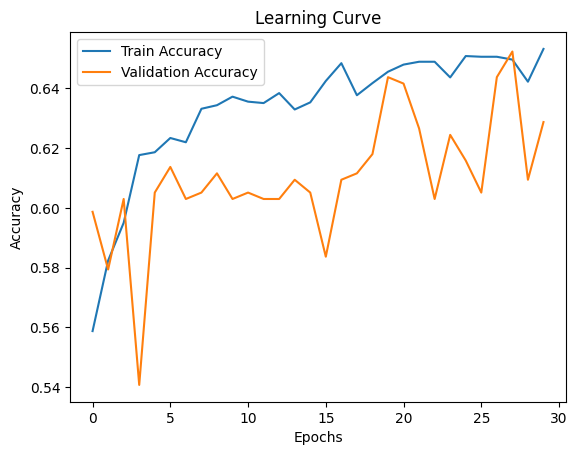

In [8]:
# Define the CNN model for processing image features
input_feature = Input(shape=(5, 5, 18))

# Convolutional layers with increasing filters, dropout, batch normalization
x = Conv2D(8, (3, 3), activation='relu')(input_feature)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(16, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)


x = Dropout(0.2)(x)

x = Flatten()(x)

# Define the input layer for scalar values
input_scalar = Input(shape=(2,))  

# Concatenate flattened features and scalar inputs
merged_input = Concatenate()([x, input_scalar])

# Hidden layer with fewer neurons, dropout, and batch normalization
x = Dense(32, activation='relu')(merged_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_feature, input_scalar], outputs=output)

# Use the Adam optimizer with a learning rate of 0.001
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(
    [X_feature_train, X_scalar_train],
    y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate([X_feature_test, X_scalar_test], y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Plot learning curve
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### For the data sixe 9x9

In [9]:
# Perform train-test split with the same number of samples
X_feature_train, X_feature_test, X_scalar_train, X_scalar_test, y_train, y_test = train_test_split(
    features_9x9,
    np.column_stack((latitude, longitude)),
    label,
    test_size=0.2, random_state=42
)

Epoch 1/30


2024-01-18 09:20:49.570528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - ETA: 0s - loss: 0.7519 - accuracy: 0.5523

2024-01-18 09:20:55.520180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 7s 21ms/step - loss: 0.7519 - accuracy: 0.5523 - val_loss: 0.7378 - val_accuracy: 0.6030
Epoch 2/30
263/263 [==============================] - 5s 20ms/step - loss: 0.6856 - accuracy: 0.5931 - val_loss: 0.6682 - val_accuracy: 0.6030
Epoch 3/30
263/263 [==============================] - 5s 19ms/step - loss: 0.6868 - accuracy: 0.5793 - val_loss: 0.6625 - val_accuracy: 0.5858
Epoch 4/30
263/263 [==============================] - 5s 19ms/step - loss: 0.6765 - accuracy: 0.6053 - val_loss: 0.6614 - val_accuracy: 0.6116
Epoch 5/30
263/263 [==============================] - 5s 19ms/step - loss: 0.6695 - accuracy: 0.6031 - val_loss: 0.6598 - val_accuracy: 0.6116
Epoch 6/30
263/263 [==============================] - 5s 18ms/step - loss: 0.6689 - accuracy: 0.6046 - val_loss: 0.6594 - val_accuracy: 0.6052
Epoch 7/30
263/263 [==============================] - 5s 19ms/step - loss: 0.6643 - accuracy: 0.6046 - val_loss: 0.6579 - val_accuracy: 0.6030
Epoch 8/30

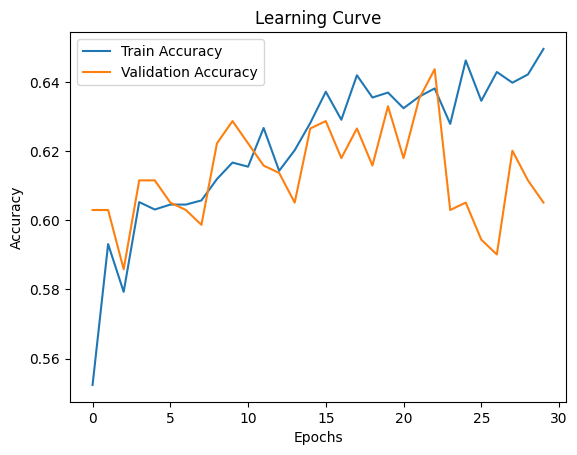

In [10]:
# Define the CNN model for processing image features
input_feature = Input(shape=(9, 9, 18))

# Convolutional layers with increasing filters, dropout, batch normalization, and max pooling
x = Conv2D(8, (3, 3), activation='relu')(input_feature)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(16, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(32, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)




x = Flatten()(x)

# Define the input layer for scalar values
input_scalar = Input(shape=(2,))  

# Concatenate flattened features and scalar inputs
merged_input = Concatenate()([x, input_scalar])

# Additional hidden layer with fewer neurons, dropout, and batch normalization
x = Dense(64, activation='relu')(merged_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_feature, input_scalar], outputs=output)

# Use the Adam optimizer with a learning rate of 0.001
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(
    [X_feature_train, X_scalar_train],
    y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate([X_feature_test, X_scalar_test], y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Plot learning curve
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




### For the data size 15x15

In [11]:
# Perform train-test split with the same number of samples
X_feature_train, X_feature_test, X_scalar_train, X_scalar_test, y_train, y_test = train_test_split(
    features_15x15,
    np.column_stack((latitude, longitude)),
    label,
    test_size=0.2, random_state=42
)

Epoch 1/30


2024-01-18 09:23:19.868123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - ETA: 0s - loss: 0.7146 - accuracy: 0.5698

2024-01-18 09:23:27.672264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 9s 26ms/step - loss: 0.7146 - accuracy: 0.5698 - val_loss: 0.6893 - val_accuracy: 0.5880
Epoch 2/30
263/263 [==============================] - 5s 20ms/step - loss: 0.6711 - accuracy: 0.6012 - val_loss: 0.7025 - val_accuracy: 0.5858
Epoch 3/30
263/263 [==============================] - 5s 19ms/step - loss: 0.6645 - accuracy: 0.6079 - val_loss: 0.6866 - val_accuracy: 0.6030
Epoch 4/30
263/263 [==============================] - 5s 20ms/step - loss: 0.6644 - accuracy: 0.6046 - val_loss: 0.6859 - val_accuracy: 0.6116
Epoch 5/30
263/263 [==============================] - 5s 20ms/step - loss: 0.6653 - accuracy: 0.6117 - val_loss: 0.6641 - val_accuracy: 0.6202
Epoch 6/30
263/263 [==============================] - 5s 20ms/step - loss: 0.6638 - accuracy: 0.6132 - val_loss: 0.6793 - val_accuracy: 0.5923
Epoch 7/30
263/263 [==============================] - 5s 20ms/step - loss: 0.6600 - accuracy: 0.6098 - val_loss: 0.6651 - val_accuracy: 0.6159
Epoch 8/30

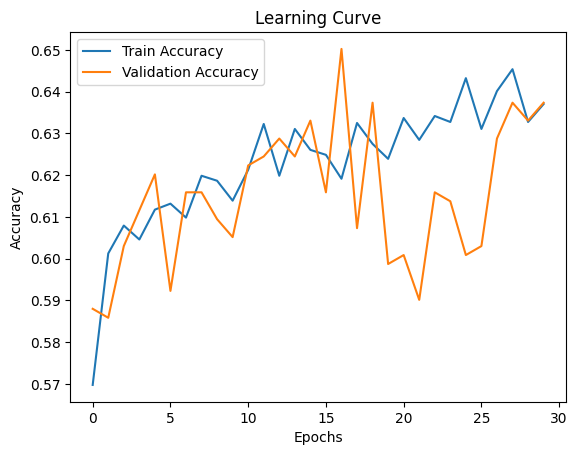

In [12]:
# Define the CNN model for processing image features
input_feature = Input(shape=(15, 15, 18))

# Convolutional layers with increasing filters, dropout, batch normalization, and max pooling
x = Conv2D(8, (3, 3), activation='relu')(input_feature)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(16, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(32, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)




x = Flatten()(x)

# Define the input layer for scalar values
input_scalar = Input(shape=(2,))  

# Concatenate flattened features and scalar inputs
merged_input = Concatenate()([x, input_scalar])

# Additional hidden layer with fewer neurons, dropout, and batch normalization
x = Dense(64, activation='relu')(merged_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_feature, input_scalar], outputs=output)

# Use the Adam optimizer with a learning rate of 0.001
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(
    [X_feature_train, X_scalar_train],
    y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate([X_feature_test, X_scalar_test], y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Plot learning curve
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




Epoch 1/30


2024-01-18 09:25:56.347752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 09:25:56.659341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 09:25:57.504260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - ETA: 0s - loss: 0.7750 - accuracy: 0.5488

2024-01-18 09:26:08.324511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 09:26:08.413203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 14s 42ms/step - loss: 0.7750 - accuracy: 0.5488 - val_loss: 0.6626 - val_accuracy: 0.6073
Epoch 2/30
263/263 [==============================] - 9s 33ms/step - loss: 0.6902 - accuracy: 0.5876 - val_loss: 0.6579 - val_accuracy: 0.6009
Epoch 3/30
263/263 [==============================] - 9s 33ms/step - loss: 0.6861 - accuracy: 0.5798 - val_loss: 0.6640 - val_accuracy: 0.6137
Epoch 4/30
263/263 [==============================] - 9s 35ms/step - loss: 0.6807 - accuracy: 0.5915 - val_loss: 0.6625 - val_accuracy: 0.6159
Epoch 5/30
263/263 [==============================] - 9s 35ms/step - loss: 0.6699 - accuracy: 0.5989 - val_loss: 0.6540 - val_accuracy: 0.6352
Epoch 6/30
263/263 [==============================] - 8s 32ms/step - loss: 0.6672 - accuracy: 0.5986 - val_loss: 0.6677 - val_accuracy: 0.6180
Epoch 7/30
263/263 [==============================] - 8s 32ms/step - loss: 0.6666 - accuracy: 0.6153 - val_loss: 0.6684 - val_accuracy: 0.6288
Epoch 8/3

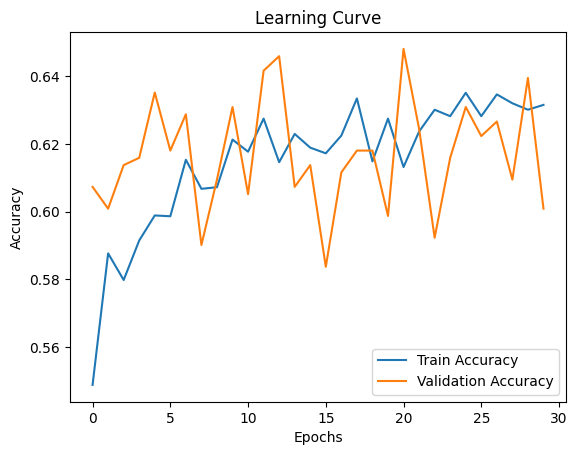

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, Concatenate, LSTM
import matplotlib.pyplot as plt

# Define the CNN model for processing image features
input_feature = Input(shape=(15, 15, 18))

x = Conv2D(8, (3, 3), activation='relu')(input_feature)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(16, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(32, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Flatten()(x)

# Define the input layer for scalar values
input_scalar = Input(shape=(2,))

# Add an RNN layer (LSTM) for sequential data
rnn_input = tf.keras.layers.Reshape((15 * 15, 18))(input_feature)  # Reshape for LSTM input
rnn_output = LSTM(64)(rnn_input)

# Concatenate flattened features, scalar inputs, and RNN output
merged_input = Concatenate()([x, input_scalar, rnn_output])

# Additional hidden layer with fewer neurons, dropout, and batch normalization
x = Dense(64, activation='relu')(merged_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_feature, input_scalar], outputs=output)

# Use the Adam optimizer with a learning rate of 0.001
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(
    [X_feature_train, X_scalar_train],
    y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate([X_feature_test, X_scalar_test], y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Plot learning curve
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
